## Importação das bibliotecas necessárias

In [ ]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from shapely.geometry import Point, Polygon
import os

# Configura o OSMnx para não mostrar logs excessivos e usar cache
ox.settings.log_console=False
ox.settings.use_cache=True

print("Bibliotecas instaladas e importadas.")

Bibliotecas instaladas e importadas.


In [11]:
def converter_para_multigrafo_nao_direcionado(G):
    """Converte um MultiDiGraph direcionado para um MultiGraph não-direcionado.

    Esta função transforma o grafo direcionado (como o retornado pelo OSMnx)
    em um networkx.MultiGraph não-direcionado, preservando atributos de
    nós, arestas e atributos ao nível do grafo.

    Argumentos:
        G (networkx.MultiDiGraph): Grafo direcionado a ser convertido.

    Retorno:
        networkx.MultiGraph: MultiGraph não-direcionado com os mesmos atributos.
    """
    H = nx.MultiGraph()
    # Copiar nós e seus atributos
    for n, data in G.nodes(data=True):
        H.add_node(n, **data)

    # Copiar arestas e seus atributos (não-direcionado). Em um MultiGraph,
    # arestas paralelas são permitidas, então múltiplas arestas direcionadas
    # se tornam arestas paralelas.
    for u, v, data in G.edges(data=True):
        H.add_edge(u, v, **data)

    # Copiar atributos do grafo
    H.graph.update(G.graph)
    return H

def extrair_localizacoes_pois(pois):
    """Extrai pares latitude/longitude de um GeoDataFrame de POIs."""
    """
    Argumentos:
        pois (GeoDataFrame): GeoDataFrame de POIs com coluna 'geometry'.

    Retorno:
        list[tuple]: Lista de tuplas (lat, lon) para POIs (pontos ou centróides de polígonos).
    """
    poi_locations = []
    for _, row in pois.iterrows():
        geom = row.geometry
        if isinstance(geom, Point):
            poi_locations.append((geom.y, geom.x))
        elif isinstance(geom, Polygon):
            poi_locations.append((geom.centroid.y, geom.centroid.x))
    return poi_locations

def obter_nos_poi_mais_proximos(G, poi_locations):
    """Mapeia coordenadas de POIs para nós mais próximos no grafo e retorna nós únicos."""
    """
    Argumentos:
        G (networkx.Graph): Grafo usado para busca de nós (grafo OSMnx).
        poi_locations (list[tuple]): Lista de coordenadas (lat, lon) dos POIs.

    Retorno:
        list: IDs únicos de nós mais próximos dos POIs.
    """
    lats = [loc[0] for loc in poi_locations]
    lons = [loc[1] for loc in poi_locations]
    poi_nodes = ox.distance.nearest_nodes(G, X=lons, Y=lats)
    return list(set(poi_nodes))

def heuristica_distancia_great_circle(G):
    """Retorna uma função heurística que calcula a distância de grande círculo entre nós."""
    def heuristic(u, v):
        node_u = G.nodes[u]
        node_v = G.nodes[v]
        return ox.distance.great_circle(node_u['y'], node_u['x'], node_v['y'], node_v['x'])
    return heuristic

def construir_grafo_interesse(G, poi_nodes, heuristic):
    """Constrói um grafo completo de POIs onde o peso das arestas é o comprimento por A*."""
    """
    Argumentos:
        G (networkx.Graph): Grafo de navegação subjacente (não-direcionado).
        poi_nodes (list): IDs de nós correspondentes aos POIs.
        heuristic (callable): Função heurística para A* (u, v) -> distância.

    Retorno:
        (networkx.Graph, dict): Grafo completo de POIs (com pesos) e mapeamento de arestas para rotas.
    """
    G_interest = nx.Graph()
    poi_routes = {}
    for i in range(len(poi_nodes)):
        for j in range(i + 1, len(poi_nodes)):
            u_node = poi_nodes[i]
            v_node = poi_nodes[j]
            try:
                route = nx.astar_path(G, u_node, v_node, heuristic=heuristic, weight='length')
                route_length = nx.path_weight(G, route, weight='length')
                G_interest.add_edge(u_node, v_node, weight=route_length)
                poi_routes[tuple(sorted((u_node, v_node)))] = route
            except nx.NetworkXNoPath:
                # Ignorar pares sem caminho (ex.: ilhas)
                print(f"Aviso: Não foi encontrado caminho entre os nós {u_node} e {v_node}.")
                continue
    return G_interest, poi_routes

def calcular_mst_de_interesse(G_interest, poi_routes):
    """Calcula a MST do grafo de interesse e mapeia para as rotas reais."""
    mst_edges = list(nx.minimum_spanning_edges(G_interest, data=True))
    total_mst_length = sum([d['weight'] for (u, v, d) in mst_edges])
    mst_routes = []
    for (u, v, d) in mst_edges:
        route_key = tuple(sorted((u, v)))
        if route_key in poi_routes:
            mst_routes.append(poi_routes[route_key])
    return mst_edges, total_mst_length, mst_routes

def plotar_mst_no_grafo(G, mst_routes, poi_nodes, tags_poi, place_name, total_mst_length):
    """Plota as rotas da MST sobre o grafo da cidade e destaca os POIs."""
    fig, ax = ox.plot_graph_routes(
        G,
        mst_routes,
        route_colors='cyan',  # Cor das rotas da MST
        route_linewidths=1,
        route_alpha=0.8,
        node_size=0,
        edge_linewidth=0.3,
        edge_color='#999999',
        bgcolor='k',
        show=False, close=False
    )
    ax.scatter(
        [G.nodes[n]['x'] for n in poi_nodes],
        [G.nodes[n]['y'] for n in poi_nodes],
        c='magenta', s=50, zorder=5, edgecolor='black', alpha=0.9
    )
    ax.set_title(f"MST (A*) para '{tags_poi}' em {place_name}\nTotal: {total_mst_length / 1000:.2f} km",
                 fontsize=15, color='white')
    
    os.makedirs("assets", exist_ok=True)
    cidade_nome = place_name.split(',')[0]
    nome_arquivo = f"assets/{cidade_nome}_mst.png"
    fig.savefig(nome_arquivo, dpi=300, bbox_inches='tight', facecolor='k')

    plt.show()

In [12]:
def processar_cidade(nome_lugar, tags_poi):
    """Executa o pipeline A* + MST para um lugar e um conjunto de POIs."""
    """
    Esta função orquestra os passos de alto nível: baixar o grafo, extrair POIs,
    mapear POIs para nós do grafo, computar distâncias A* par-a-par, construir o grafo
    de interesse, calcular a MST e plotar as rotas resultantes.

    Argumentos:
        nome_lugar (str): String de lugar aceita pelo OSMnx (ex.: 'Cidade, Estado, País').
        tags_poi (dict): Dicionário de tags OSM para selecionar POIs (ex.: {'tourism': 'museum'}).

    Retorno:
        dict ou None: Resumo de métricas ou None em caso de falha.
    """
    print(f"--- Iniciando processamento para: {nome_lugar} ---")
    try:
        # Baixar grafo de direção para veículos
        G_direcionado = ox.graph_from_place(nome_lugar, network_type='drive')

        # Converter para não-direcionado para rotas e MST
        G = converter_para_multigrafo_nao_direcionado(G_direcionado)

        pois = ox.features.features_from_place(nome_lugar, tags=tags_poi)

        # Extrair coordenadas dos POIs e mapear para nós mais próximos
        poi_locations = extrair_localizacoes_pois(pois)
        if len(poi_locations) < 2:
            print(f"POIs insuficientes ({len(poi_locations)}) em {nome_lugar}. Pulando.")
            return None

        poi_nodes = obter_nos_poi_mais_proximos(G_direcionado, poi_locations)
        if len(poi_nodes) < 2:
            print(f"Nós únicos insuficientes ({len(poi_nodes)}) em {nome_lugar}. Pulando.")
            return None
        print(f"Encontrados {len(poi_nodes)} nós de POI únicos.")

        # Construir grafo de interesse completo usando distâncias por A*
        heuristic = heuristica_distancia_great_circle(G)
        G_interest, poi_routes = construir_grafo_interesse(G, poi_nodes, heuristic)

        # Calcular MST e obter rotas reais para visualização
        mst_edges, total_mst_length, mst_routes = calcular_mst_de_interesse(G_interest, poi_routes)

        print(f"Comprimento total da MST para {nome_lugar}: {total_mst_length / 1000:.2f} km")

        # Plotar resultados
        plotar_mst_no_grafo(G, mst_routes, poi_nodes, tags_poi, nome_lugar, total_mst_length)

        return {
            "Cidade": nome_lugar.split(',')[0],
            "Num POIs": len(poi_nodes),
            "MST Comprimento (m)": total_mst_length,
            "Num Arestas MST": len(mst_edges)
        }
    except Exception as e:
        print(f"ERRO ao processar {nome_lugar}: {e}")
        return None

print("Função principal 'processar_cidade' definida.")

Função principal 'processar_cidade' definida.


--- Iniciando processamento para: Natal, Rio Grande do Norte, Brazil ---
Encontrados 13 nós de POI únicos.
Comprimento total da MST para Natal, Rio Grande do Norte, Brazil: 19.63 km
ERRO ao processar Natal, Rio Grande do Norte, Brazil: [Errno 2] No such file or directory: 'assets/Natal_mst.png'
--- Iniciando processamento para: Recife, Pernambuco, Brazil ---


KeyboardInterrupt: 

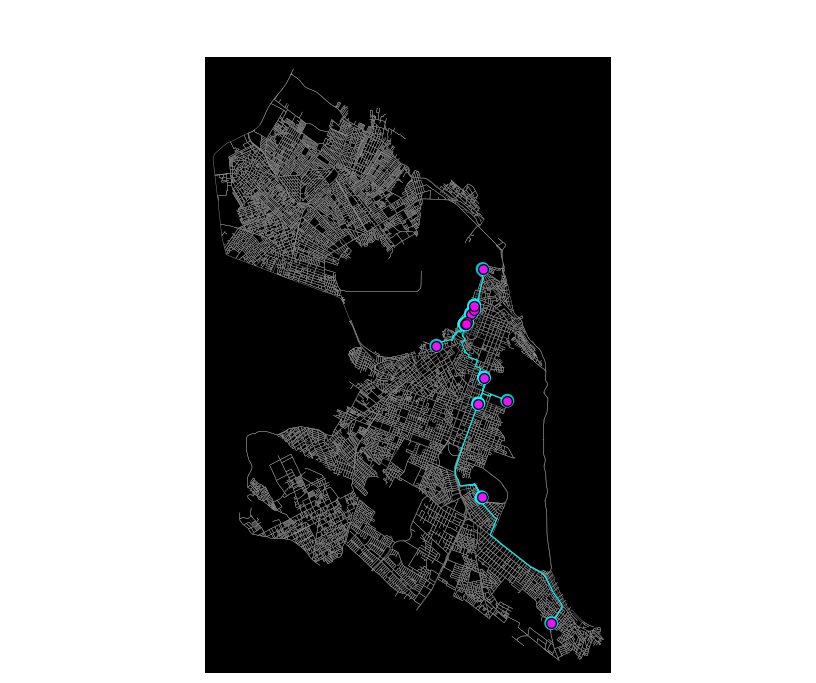

In [8]:
tags = {'tourism': 'museum'}

cidades_para_analise = [
    "Natal, Rio Grande do Norte, Brazil",
    "Recife, Pernambuco, Brazil",
    "Fortaleza, Ceará, Brazil",
    "Salvador, Bahia, Brazil",
    "João Pessoa, Paraíba, Brazil",
    "Maceió, Alagoas, Brazil",
    "São Luís, Maranhão, Brazil",
    "Teresina, Piauí, Brazil",
    "Aracaju, Sergipe, Brazil"
]

# Coletar resultados
resultados = []
for cidade in cidades_para_analise:
    # Chama a função principal refatorada
    res = processar_cidade(cidade, tags)
    if res:
        resultados.append(res)

print("\n\n--- Processamento de todas as cidades concluído! ---")

if resultados:
    df_resultados = pd.DataFrame(resultados)

    # Calcular métricas adicionais (Item 5 da tarefa)
    df_resultados['MST Comprimento (km)'] = (df_resultados['MST Comprimento (m)'] / 1000).round(2)

    # Média e Desvio Padrão por POI (km/POI)
    df_resultados['km / POI'] = (df_resultados['MST Comprimento (km)'] / df_resultados['Num POIs']).round(3)

    # Média e Desvio Padrão por par conectado da MST (km/aresta-MST)
    df_resultados['km / Aresta MST'] = (df_resultados['MST Comprimento (km)'] / df_resultados['Num Arestas MST']).round(2)


    # Exibir a tabela comparativa final
    print(f"\n--- Tabela Comparativa (POIs: {tags}) ---")

    # Define a ordem das colunas para melhor visualização
    colunas_finais = ['Cidade', 'Num POIs', 'MST Comprimento (km)', 'km / POI', 'km / Aresta MST']
    display(df_resultados[colunas_finais].sort_values(by='MST Comprimento (km)', ascending=False))

    # Calcular Média e Desvio Padrão das métricas (Item 5)
    print("\n--- Estatísticas Gerais ---")
    print(f"Média de km/POI: {df_resultados['km / POI'].mean():.2f} km")
    print(f"Desvio Padrão de km/POI: {df_resultados['km / POI'].std():.2f} km")

    print(f"\nMédia de km/Aresta MST: {df_resultados['km / Aresta MST'].mean():.2f} km")
    print(f"Desvio Padrão de km/Aresta MST: {df_resultados['km / Aresta MST'].std():.2f} km")

else:
    print("Nenhum resultado foi processado com sucesso.")